In [2]:
from ultis import *
import neal
from docplex.mp.model import Model
from dwave.system import LeapHybridCQMSampler
import dwave.inspector
import dimod
import matplotlib.pyplot as plt
%matplotlib widget

### Create functions to define quadratic model

In [3]:
def define_variables(costs, model):
    var = set()
    for ijk in costs.keys():
        i, j, k = ijk[0], ijk[1], ijk[2]
        var.add((i, j))
        var.add((j, k))
    var = sorted(var, key=lambda x: (x[0], x[1]))
    x = model.binary_var_dict(var, name='x')
    return x


In [4]:
def create_model(costs, hits, hits_by_layers, alpha, model_path_out):
    NL = len(hits_by_layers.keys())
    print("Number of layers: ", NL)

    model = Model(name="Track finding")
    model.float_precision = 8
    x = define_variables(costs, model)
    ob_funct = model.sum(-w * alpha * x[(ijk[0], ijk[1])] * x[(ijk[1], ijk[2])] for ijk, w in costs.items())
    model.minimize(ob_funct)
    for h in hits:
        k = h.index
        constraint_out = []
        constraint_in = []
        for k_1 in x.keys():
            if ((h.layer_id < (NL - 1)) and (k_1[0] == k)):
                constraint_out.append(x[(k_1[0], k_1[1])])
            if ((h.layer_id > 0) and (k_1[1] == k)):
                constraint_in.append(x[(k_1[0], k_1[1])])
        if (len(constraint_out) > 0):
            model.add_constraint(model.sum(constraint_out) == 1)
        if (len(constraint_in) > 0):
            model.add_constraint(model.sum(constraint_in) == 1)

    model.export_as_lp(model_path_out)
    model = dimod.lp.load(model_path_out)
    return model

### Create function to Dwave solver

In [5]:
def dwave_solver(cqm, no_track):
    # Initialize the CQM solver
    sampler = LeapHybridCQMSampler()
    # Solve the problem using the CQM solver
    model_name = str(no_track) + ' Track D-QCBM'
    sampleset = sampler.sample_cqm(cqm, label=model_name)
    # print(sampleset)
    feasible_sampleset = sampleset.filter(lambda row: row.is_feasible)

    try:
        sample = feasible_sampleset.first.sample
        ob_value = feasible_sampleset.first.energy
        run_time = sampleset.info['run_time'] / 1000000
    except:
        print("\nNo feasible solutions found.")
        exit()

    return ob_value, sample, run_time

### Display result

In [6]:
def display(list_hits, result, out=""):
    segments = list()
    for k, v in result.items():
        if v == 1:
            if type(k) is str:
                k = [int(e) for e in k.split('_')[1:]]
            h_1 = list_hits[k[0]]
            h_2 = list_hits[k[1]]
            segments.append([h_1, h_2])
    print("No_segments:", len(segments))
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    xs = []
    ys = []
    zs = []

    for h in list_hits:
        xs.append(h.x)
        ys.append(h.y)
        zs.append(h.z)
    ax.scatter(xs, ys, zs, marker='o', color='red')

    for segment in segments:
        h1 = segment[0]
        h2 = segment[1]
        ax.plot(xs=[h1.x, h2.x], ys=[h1.y, h2.y], zs=[h1.z, h2.z], color='blue')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.savefig(out)
    plt.show()

In [7]:
def run_script(no_tracks, beta_max, m, alpha, gamma):
    src_path = '../../src/data_selected'
    folder = '/'+ str(no_tracks)+'hits/known_track/'
    out_path = 'results'
    data_path = src_path + folder + 'hits.csv'
    figure_path_out = out_path + folder + "result_D_QCBM.PNG"
    check_path(out_path + folder)
    
    # read data
    print("Loading data...")
    start = time.time()
    hits_by_layers, hits = read_hits(data_path)
    end = time.time()
    print("Loaded data! Execution time: ", end - start)

    re_calculate = False
    costs_path_out = out_path + folder + "pi_" + str(A) + "costs.json"
    if os.path.exists(costs_path_out) == False:
        re_calculate = True
    if re_calculate:
        # calculate costs
        print("\n----Compute cost----")
        start = time.time()
        costs = get_costs(hits_by_layers, beta_max)
        end = time.time()
        print('Complete!. Execution time: ', end - start, 's')
    
        print("\n---Write cost out---")
        print("Path: ", costs_path_out)
        write_costs(costs, costs_path_out, m)
    
    # load data
    print("---Load cost---")
    costs = load_costs(costs_path_out)
    print("---Loaded cost---")

    print("\n ----Create Hamiltonian----")
    model_path_out = out_path + folder + "model_D_QCBM.lp"
    model = create_model(costs, hits, hits_by_layers, alpha, model_path_out)
    print("----Created Hamiltonian----")

    print("\n----Dwave CQM Hybird Solver----")
    ob_value, sample, run_time = dwave_solver(model, no_tracks)
    print("Objective value:", ob_value / alpha)
    print("Run time:", run_time)
    cal_expected_value(hits, m)
    display(hits, sample, out=figure_path_out)

Loading data...
Loaded data! Execution time:  0.0322418212890625
---Load cost---
---Loaded cost---

 ----Create Hamiltonian----
Number of layers:  7
----Created Hamiltonian----

----Dwave CQM Hybird Solver----
Objective value: -0.48983364473297486
Run time: 7.756339
Expected cost : -3.4719486020214205
Expected No. segments : 1200
No_segments: 1200


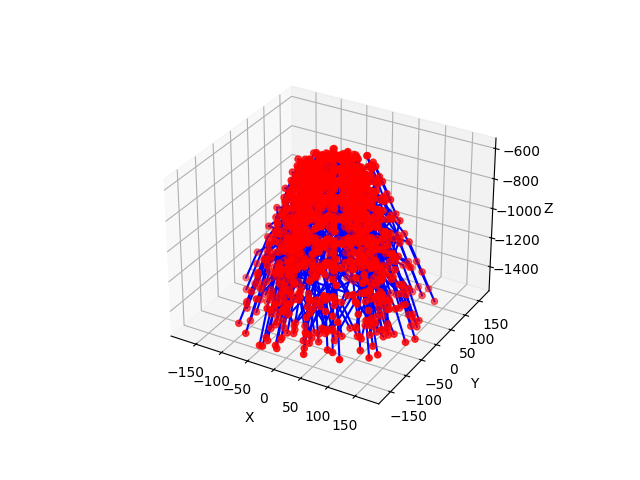

In [16]:
if __name__ == '__main__': # Keep this line if we want to run multiprocessing
    no_tracks = 200
    # weight
    A = 300
    beta_max = math.pi / A
    m = 1
    alpha = 200
    gamma = 1
    run_script(no_tracks, beta_max, m, alpha, gamma)

In [14]:
plt.close()